In [1]:
import itertools

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import (
roc_curve, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, recall_score,
    f1_score, accuracy_score
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd

import pyreadstat

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator, FuncFormatter

import seaborn as sns

from sklearn.preprocessing import StandardScaler

import numpy as np

from my_funcs import *

## Импорт датасетов

In [3]:
raw_dfs_info = {
    '2020': {
        'path': 'GEM 2020 APS Global Individual Level Data_Jan2022.sav',
        'col_names': ['bstartyy', 'bjobstyy', 'gender', 'age', 'hhsize', 'gemhhinc', 'knowenyy', 'opportyy', 
                      'suskilyy', 'frfailyy', 'easystyy', 'equaliyy', 'nbgoodyy', 'nbstatyy', 'nbmediyy', 'country'],
        'encode': 'utf-8'
    },
    '2019': {
        'path': 'GEM 2019 APS Global Individual Level Data_30Jan2021.sav',
        'col_names': ['Bstartyy', 'BJOBSTyy', 'gender', 'age', 'hhsize', 'GEMHHINC', 'KNOWENyy', 'OPPORTyy', 
                      'SUSKILyy', 'FRFAILyy', 'EASYSTyy', 'EQUALIyy', 'NBGOODyy', 'NBSTATyy', 'NBMEDIyy', 'country'],
        'encode': 'utf-8'
    },
    '2018': {
        'path': 'GEM 2018 APS Global Individual Level Data.sav',
        'col_names': ['bstart', 'bjobst', 'gender', 'age', 'hhsize', 'GEMHHINC', 'KNOWEN18', 'OPPORT18', 
                      'SUSKIL18', 'FRFAIL18', 'easystart', 'EQUALI18', 'NBGOOD18', 'NBSTAT18', 'NBMEDI18', 'country'],
        'encode': 'ISO-8859-1'
    },
    '2017': {
        'path': 'GEM 2017 APS Global Individual Level Data_1April2021.sav',
        'col_names': ['bstart', 'bjobst', 'gender', 'age', 'hhsize', 'GEMHHINC', 'KNOWENyy', 'OPPORTyy', 
                      'SUSKILyy', 'FRFAILyy', 'easystart', 'EQUALIyy', 'NBGOODyy', 'NBSTATyy', 'NBMEDIyy', 'country'],
        'encode': 'utf-8'
    },
    '2016': {
        'path': 'GEM 2016 APS Global - Individual Level Data.sav',
        'col_names': ['bstart', 'bjobst', 'gender', 'age', 'hhsize', 'GEMHHINC', 'KNOWENyy', 'OPPORTyy', 
                      'SUSKILyy', 'FRFAILyy', 'easystart', 'EQUALIyy', 'NBGOODyy', 'NBSTATyy', 'NBMEDIyy', 'country'],
        'encode': 'utf-8'
    },
    '2015': {
        'path': 'GEM 2015 APS Global Individial Data.sav',
        'col_names': ['bstart', 'bjobst', 'gender', 'age', 'hhsize', 'GEMHHINC', 'KNOWENyy', 'OPPORTyy', 
                      'SUSKILyy', 'FRFAILyy', 'easystart', 'EQUALIyy', 'NBGOODyy', 'NBSTATyy', 'NBMEDIyy', 'country'],
        'encode': 'utf-8'
    }
}

df = {}

for year, info in raw_dfs_info.items():
    temp_df, meta = pyreadstat.read_sav(info['path'], encoding=info['encode'])
    temp_df = temp_df[info['col_names']].copy()  # Оставляем только нужные колонки
    df[year] = temp_df  # Сохраняем DataFrame по году

## Стандартизация датасетов

In [5]:
# Переназвать столбцы
# У каждого датасета bstart и bjobst должны быть превращены в NTRPR и выкинуты
# Гендер убедиться чем является 0 и 1, а так же где 1 и 2 привести к 0 и 1

rename_dict = {
    'gender': ['gender', 'gender', 'gender', 'gender', 'gender', 'gender'],
    'age': ['age', 'age', 'age', 'age', 'age', 'age'],
    'household_size': ['hhsize', 'hhsize', 'hhsize', 'hhsize', 'hhsize', 'hhsize'],
    'household_income': ['gemhhinc', 'GEMHHINC', 'GEMHHINC', 'GEMHHINC', 'GEMHHINC', 'GEMHHINC'],
    'knows_entrepreneurs': ['knowenyy', 'KNOWENyy', 'KNOWEN18', 'KNOWENyy', 'KNOWENyy', 'KNOWENyy'],
    'sees_opportunity': ['opportyy', 'OPPORTyy', 'OPPORT18', 'OPPORTyy', 'OPPORTyy', 'OPPORTyy'],
    'has_business_skills': ['suskilyy', 'SUSKILyy', 'SUSKIL18', 'SUSKILyy', 'SUSKILyy', 'SUSKILyy'],
    'fears_failure': ['frfailyy', 'FRFAILyy', 'FRFAIL18', 'FRFAILyy', 'FRFAILyy', 'FRFAILyy'],
    'thinks_startup_easy': ['easystyy', 'EASYSTyy', 'easystart', 'easystart', 'easystart', 'easystart'],
    'supports_equality': ['equaliyy', 'EQUALIyy', 'EQUALI18', 'EQUALIyy', 'EQUALIyy', 'EQUALIyy'],
    'entrepreneur_popular': ['nbgoodyy', 'NBGOODyy', 'NBGOOD18', 'NBGOODyy', 'NBGOODyy', 'NBGOODyy'],
    'high_status_view': ['nbstatyy', 'NBSTATyy', 'NBSTAT18', 'NBSTATyy', 'NBSTATyy', 'NBSTATyy'],
    'media_attention': ['nbmediyy', 'NBMEDIyy', 'NBMEDI18', 'NBMEDIyy', 'NBMEDIyy', 'NBMEDIyy'],
    'bstart': ['bstartyy', 'Bstartyy', 'bstart', 'bstart', 'bstart', 'bstart'],
    'bjobst': ['bjobstyy', 'BJOBSTyy', 'bjobst', 'bjobst', 'bjobst', 'bjobst']
}

standartized_df = {}

# Идем по каждому году и переименовываем столбцы
for year, inner in df.items():

    # Стандартизируем столбцы
    rename_map = {}
    for new_col, old_cols in rename_dict.items():
        for old_col in old_cols:
            if old_col in inner.columns:
                rename_map[old_col] = new_col

    # Переименовываем столбцы в DataFrame
    temp_df = inner.rename(columns=rename_map)

    # Четко обозначим переменную пола
    temp_df['male'] = (temp_df['gender'] == 1).astype(int) if (
        2 in temp_df['gender'].unique()
    ) else (temp_df['gender'] == 'Male').astype(int)

    # Создадим дамми-переменные дохода, базовый класс - средний
    temp_df['low_income'] = (temp_df['household_income'] == 33).astype(int)
    temp_df['high_income'] = (temp_df['household_income'] == 68100).astype(int)

    # Создаем столбец предпринимателя
    temp_df['enterpreneur'] = temp_df.apply(
        lambda row: int(
        any([row['bstart'] == 1, row['bjobst'] == 1]
           )
    ), axis=1)
    
    # Иначе странно будет интерпретировать 0 членов семьи, а такой показатель есть в некоторых годах
    temp_df = temp_df[temp_df['household_size']>0]
    temp_df = temp_df[temp_df['age']>0] # Тут не проверял, но на всякий случай
    
    # Выкинем столбцы, из которых мы сделали предыдущий
    temp_df.drop(['bstart', 'bjobst'], inplace=True, axis=1) # Предпринимателя
    temp_df.drop(['household_income'], inplace=True, axis=1) # Категория доходов
    temp_df.drop(['gender'], inplace=True, axis=1) # Пол

    # Сохраняем очищенный DataFrame в clean_df
    standartized_df[year] = temp_df

In [6]:
# Почистить выбросы, где не бинарные значения в столбцах (квантилями)
def remove_outliers_iqr(df, columns):
    """
    Удаляет выбросы на основе IQR-метода.
    
    :param df: DataFrame
    :param columns: Список столбцов для очистки от выбросов
    :return: Очищенный DataFrame
    """
    cleaned_df = df.copy()
    for col in columns:
        if col in cleaned_df.columns:
            Q1 = cleaned_df[col].quantile(0.25)
            Q3 = cleaned_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df

clean_df = {}

for year, inner in standartized_df.items():

    # Выбираем по каким столбцам будем чистить выбросы
    filter_cols = ['age', 'household_size']
    
    # Чистим
    clean_df[year] = remove_outliers_iqr(inner, filter_cols)

## Предварительный анализ данных

### Рассмотрим датасет 2020 года

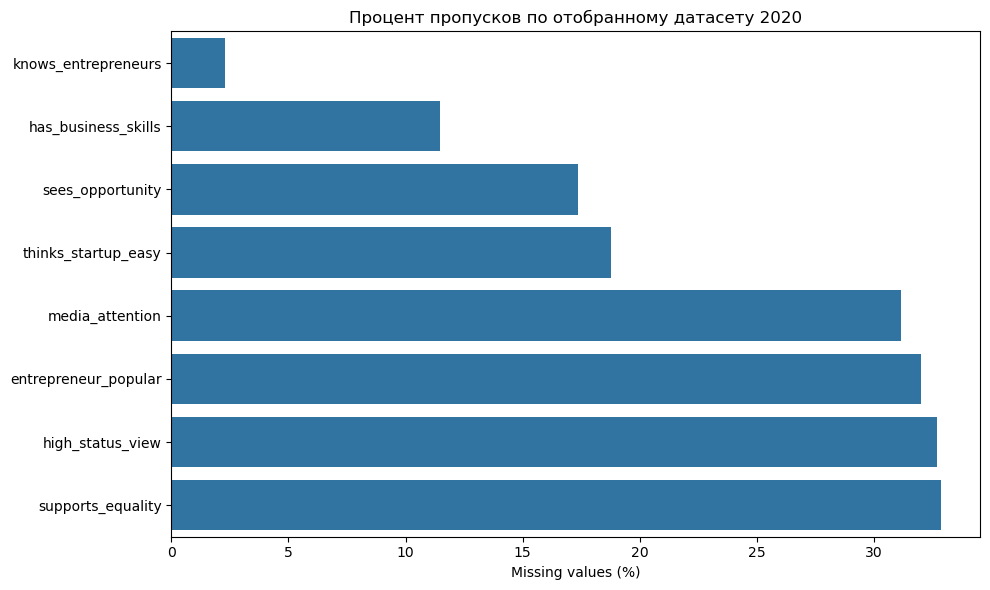

In [9]:
df_2020 = clean_df['2020'].copy()

# Посчитаем пропуски в каждом столбце
missing_percent = df_2020.isna().sum() / len(clean_df['2020']) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=True)  # Оставим только столбцы с пропусками

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.values, y=missing_percent.index, legend=False)
plt.xlabel('Missing values (%)')
plt.ylabel('')
plt.title('Процент пропусков по отобранному датасету 2020')
plt.tight_layout()
plt.show()

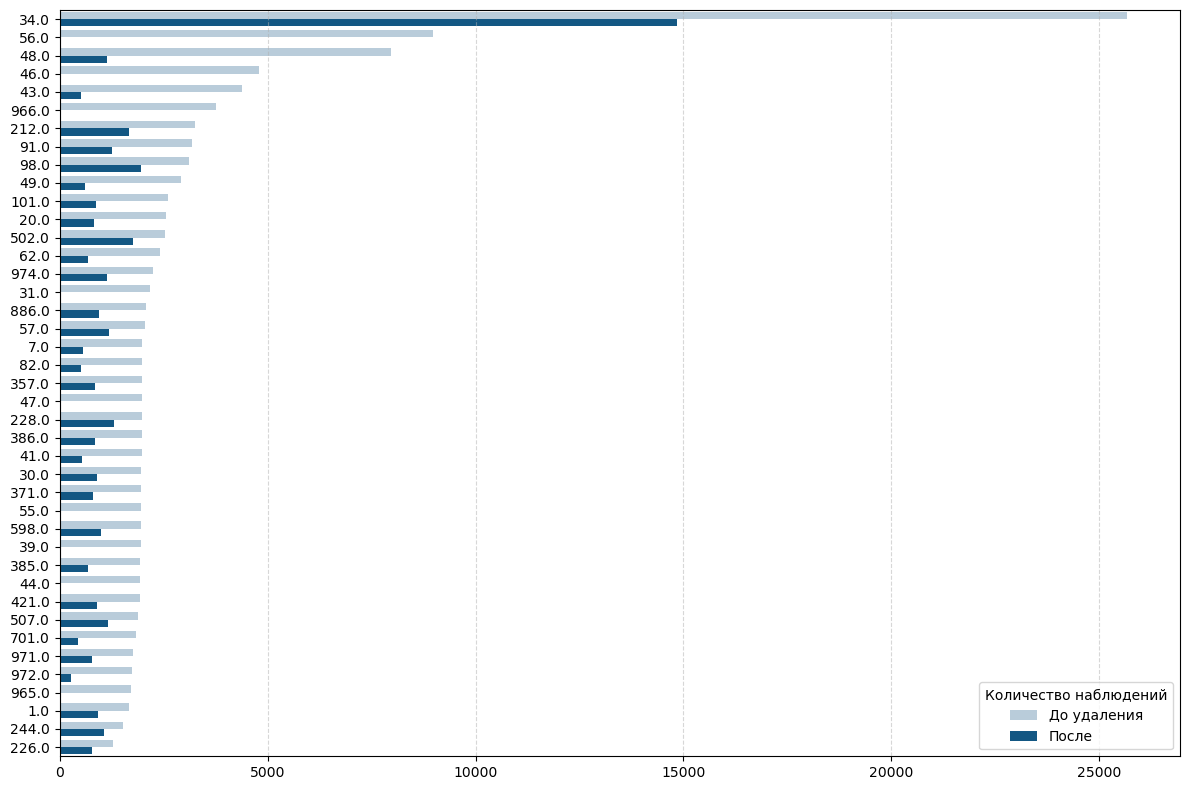

In [10]:
def plot_country_counts_comparison(df, column='country', top_n=50):
    # Подсчёты по стране до и после общего dropna
    counts_before = df[column].value_counts().rename("До удаления")

    # После удаления всех строк с любыми NaN
    df_cleaned = df.dropna()
    counts_after = df_cleaned[column].value_counts().rename("После")

    # Объединение
    df_counts = pd.concat([counts_before, counts_after], axis=1).fillna(0)
    df_counts.index.name = column

    # Сортировка по 'После'
    df_counts = df_counts.sort_values("После", ascending=False).head(top_n)

    # Перевод в long-form
    df_long = df_counts.reset_index().melt(
        id_vars=column,
        value_vars=["До удаления", "После"],
        var_name="Dataset",
        value_name="Count"
    )

    # Сортировка перед графиком по Count (чтобы порядок был)
    df_long_sorted = df_long.sort_values(by='Count', ascending=False)

    # Категориальный тип для оси Y (теперь страна по Y)
    df_long_sorted[column] = pd.Categorical(df_long_sorted[column], categories=df_long_sorted[column].unique(), ordered=True)

    # Построение горизонтального графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_long_sorted, y=column, x='Count', hue='Dataset', palette=['#b3cde0', '#005b96'])
    plt.title('')
    plt.ylabel('')
    plt.legend(title='Количество наблюдений')
    plt.xlabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_country_counts_comparison(df_2020)

In [11]:
# Соберем у каждого вопроса список стран, которым он не задавался
countries_without_questions = set()

for question in ['supports_equality', 'high_status_view', 'entrepreneur_popular', 'media_attention']:
    # Рассчитываем пропуски для каждого вопроса
    missing_by_country = df_2020.groupby('country')[question].apply(lambda x: x.isna().mean() * 100)

    # Собираем страны, где пропуски составляют 100%
    countries = set(index for index, value in missing_by_country.items() if value == 100)

    # Пересекаем текущие страны с уже найденными
    if not countries_without_questions:
        countries_without_questions = countries
    else:
        countries_without_questions &= countries  # Пересечение множеств

countries_without_questions

{31.0, 39.0, 46.0, 47.0, 55.0, 56.0, 965.0}

In [12]:
# Как вариант сначала включить эти вопросы, провести так. Потом не включить и сравнить.

ful_len = len(df_2020)
print('Полная длинна:', ful_len)

omit_len = len(df_2020.dropna())
print('Длинна с обычным выбрасыванием строк с пропусками:', omit_len)

answered_countries_len = len(df_2020[~df_2020['country'].isin(countries_without_questions)].dropna())
print('Длинна, в которой сначала выкинули страны с большими пропусками, а затем убрали остальные пропуски:', answered_countries_len)

without_that_questions_len = len(df_2020.drop(
    ['supports_equality', 'high_status_view', 'entrepreneur_popular', 'media_attention'], axis=1
).dropna())
print('Длинна датасета без пропусков и без этих вопросов:', without_that_questions_len)

Полная длинна: 129640
Длинна с обычным выбрасыванием строк с пропусками: 43637
Длинна, в которой сначала выкинули страны с большими пропусками, а затем убрали остальные пропуски: 43637
Длинна датасета без пропусков и без этих вопросов: 81997


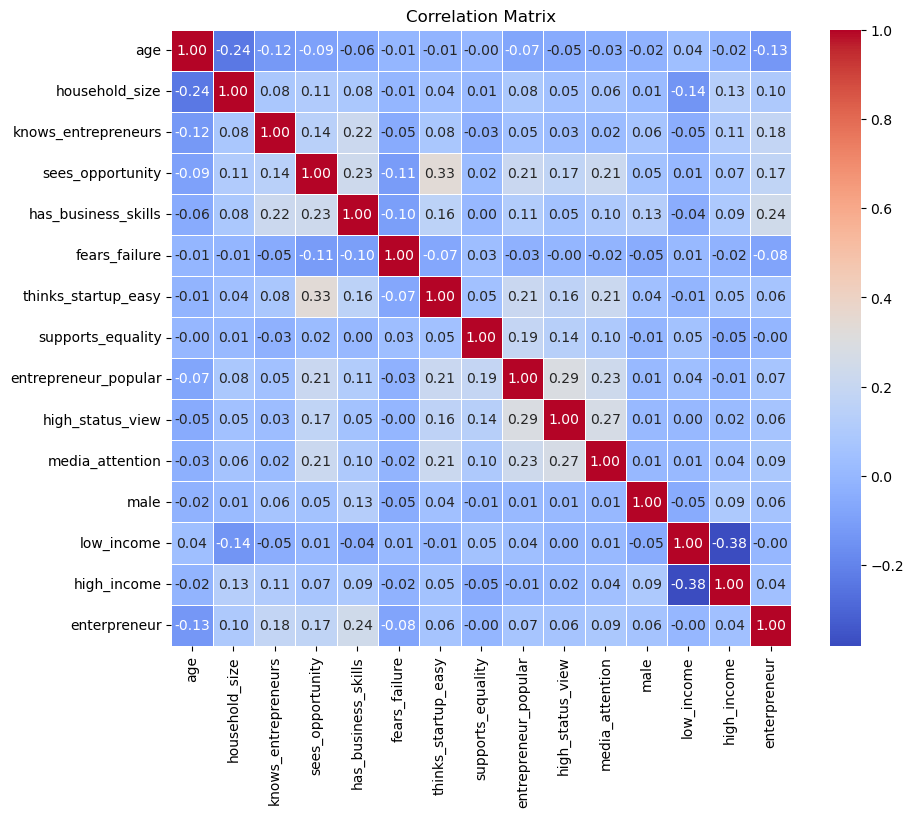

In [13]:
# Рассчитываем корреляционную матрицу
corr_matrix = df_2020.drop(['country'], axis=1).corr()

# Настроим размер графика
plt.figure(figsize=(10, 8))

# Построим тепловую карту с маской и подсветкой
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)

# Добавим заголовок
plt.title('Correlation Matrix')

# Показываем график
plt.show()

# Создание модели

## Модель 2020 года

In [16]:
# Скалируем не бинарные величины, выкинем пропуски
scaler = StandardScaler()

# Выкинем все пропуски (грубо)
omit_df_2020 = df_2020.dropna().copy()

# Скалируем значения
omit_df_2020[['age', 'household_size']] = scaler.fit_transform(omit_df_2020[['age', 'household_size']])

In [17]:
y = 'enterpreneur'
X = [
    'age', 'household_size', 'male', 'low_income', 'high_income', # Контрольные
    'knows_entrepreneurs', 'sees_opportunity', 'has_business_skills', 'fears_failure',
    'thinks_startup_easy', 'supports_equality', 'entrepreneur_popular', 'high_status_view', 'media_attention'
]


Smodel_2020 = simple_model(omit_df_2020, y, X)

Smodel_2020.show_models()

Optimization terminated successfully.
         Current function value: 0.413377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413283
         Iterations 6
Логит: 
                            Logit Regression Results                           
Dep. Variable:           enterpreneur   No. Observations:                43637
Model:                          Logit   Df Residuals:                    43622
Method:                           MLE   Df Model:                           14
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.1354
Time:                        18:38:11   Log-Likelihood:                -18039.
converged:                       True   LL-Null:                       -20863.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

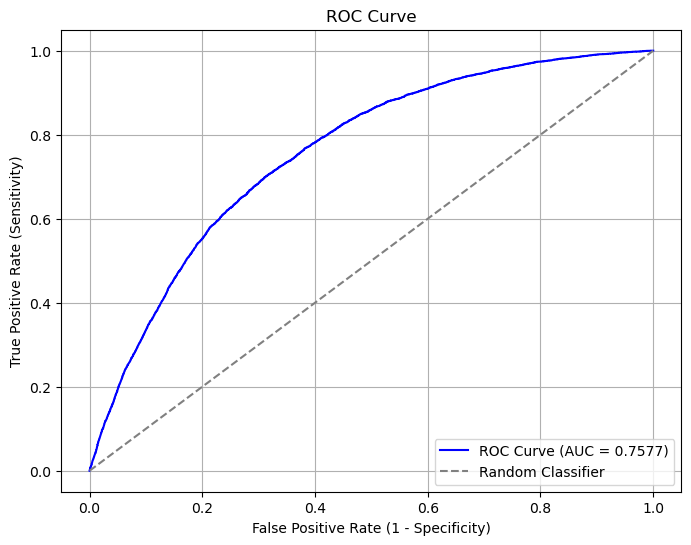

In [18]:
Smodel_2020.show_roc()

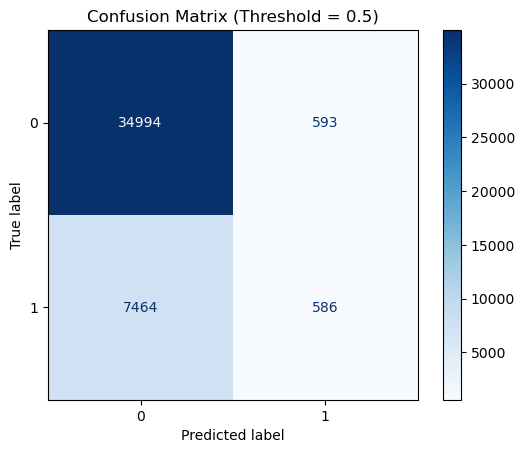

In [19]:
Smodel_2020.show_cm()

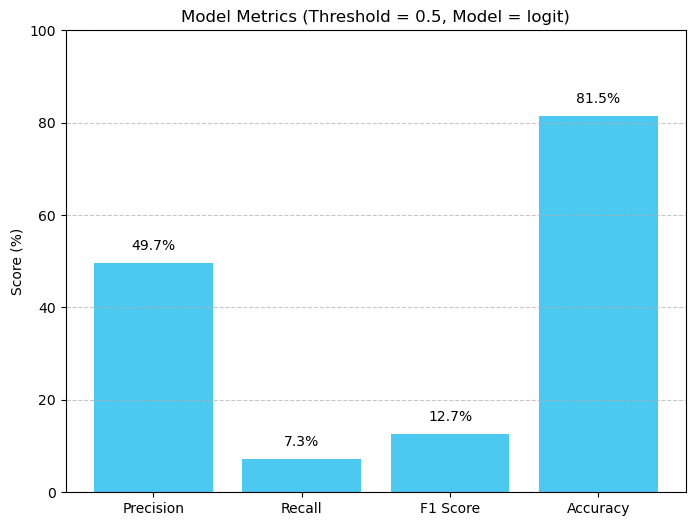

In [20]:
Smodel_2020.show_metrics()

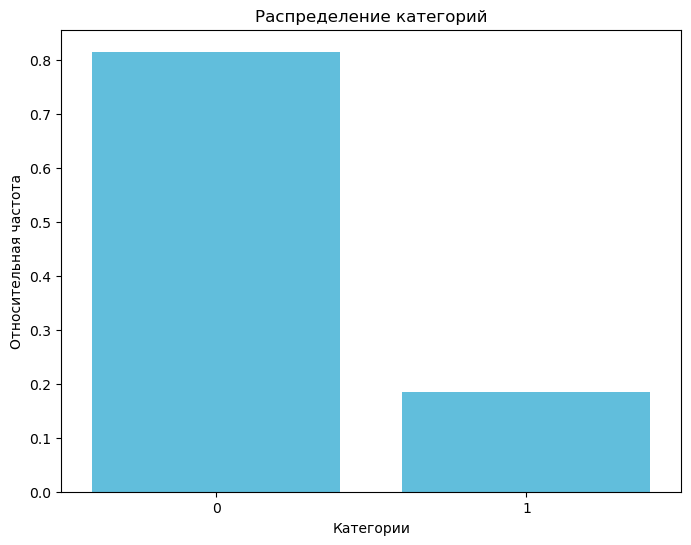

In [21]:
# Но при таком раскладе модель переобучена, а еще вырисовывается дисбаланс классов:

# Вычисляем относительные частоты
counts = omit_df_2020[y].value_counts(normalize=True)

# Строим столбчатую диаграмму
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, color="#4CC9F0")

# Настроим подписи и заголовок
plt.xlabel('Категории')
plt.ylabel('Относительная частота')
plt.title('Распределение категорий')

# Покажем график
plt.show()

In [22]:
# Более того, возможно не все регрессоры оказывают существенное влияние, покажем на примере максимизации BIC

# BIC_X = find_best_bic_model(omit_df_2020, y, X)
BIC_X = ['age', 'household_size', 'male', 'high_income', 
         'knows_entrepreneurs', 'sees_opportunity', 'has_business_skills', 
         'fears_failure', 'supports_equality', 'high_status_view', 'media_attention']

In [23]:
# Разбили на трейн и тест выборку
# Убедились что там пропорционально разбит y (stratified)
# Максимизировали f-1 score (th = 0.24)

model_2020 = normal_model(omit_df_2020, y, BIC_X)

model_2020.show_models()

Optimization terminated successfully.
         Current function value: 0.411284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411162
         Iterations 6
Логит: 
                            Logit Regression Results                           
Dep. Variable:           enterpreneur   No. Observations:                30545
Model:                          Logit   Df Residuals:                    30533
Method:                           MLE   Df Model:                           11
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.1398
Time:                        18:38:13   Log-Likelihood:                -12563.
converged:                       True   LL-Null:                       -14604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

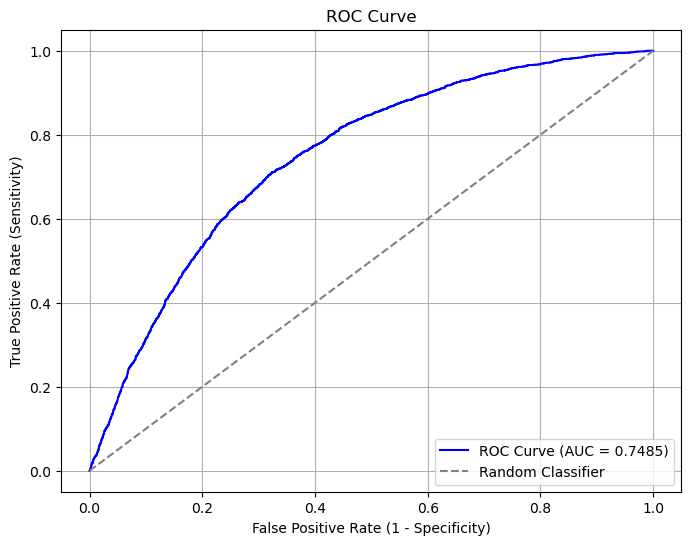

In [24]:
model_2020.show_roc()

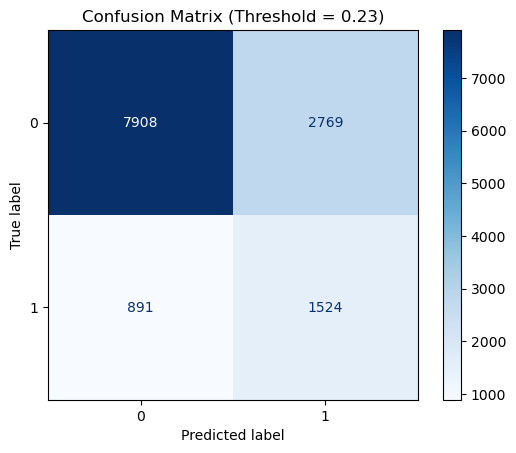

In [25]:
model_2020.show_cm()

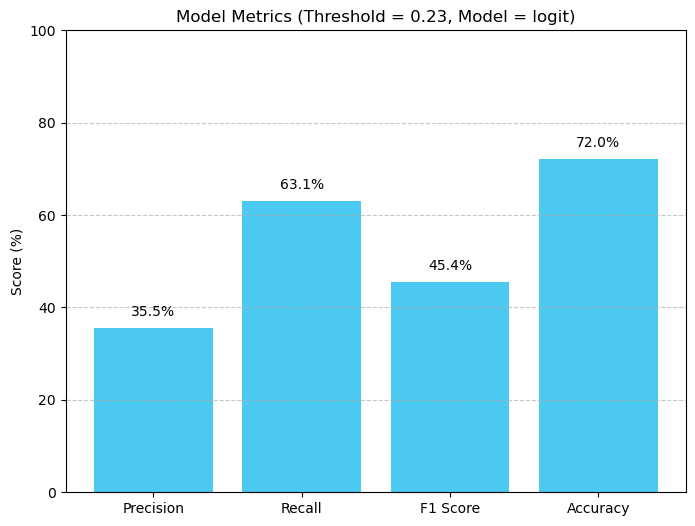

In [26]:
model_2020.show_metrics()

In [27]:
ame_2020 = model_2020.show_marginal_effects()

Средние предельные эффекты (логит-модель):

                     95% CI Lower     AME  95% CI Upper
age                       -0.0413 -0.0373       -0.0333
household_size             0.0115  0.0152        0.0188
male                       0.0023  0.0098        0.0173
high_income                0.0020  0.0101        0.0183
knows_entrepreneurs        0.0661  0.0739        0.0818
sees_opportunity           0.0701  0.0779        0.0857
has_business_skills        0.1400  0.1492        0.1584
fears_failure             -0.0493 -0.0418       -0.0342
supports_equality         -0.0299 -0.0220       -0.0142
high_status_view           0.0201  0.0292        0.0383
media_attention            0.0312  0.0397        0.0482


In [28]:
odds_2020 = model_2020.show_odds_ratios()

Отношение шансов (логит-модель):

                     Odds Ratio  95% CI Lower  95% CI Upper
const                    0.0360        0.0319        0.0406
age                      0.7316        0.7072        0.7569
household_size           1.1356        1.1014        1.1709
male                     1.0855        1.0192        1.1561
high_income              1.0888        1.0165        1.1662
knows_entrepreneurs      1.8581        1.7383        1.9861
sees_opportunity         1.9209        1.7990        2.0510
has_business_skills      3.4914        3.2106        3.7968
fears_failure            0.7046        0.6614        0.7506
supports_equality        0.8313        0.7783        0.8880
high_status_view         1.2771        1.1831        1.3785
media_attention          1.3946        1.2980        1.4984


## Сравнение AME и Odds ratio в годах

In [30]:
AME_dict = {}
odds_dict = {}

for year, df in clean_df.items():  # Используйте items() для итерирования по парам "год - DataFrame"
    omit_df = df.dropna().copy()
    omit_df[['age', 'household_size']] = scaler.fit_transform(omit_df[['age', 'household_size']])

    model = normal_model(omit_df, y, BIC_X)  # Строим модель на основе текущего df

    # Получаем средние предельные эффекты (AME) и отношение шансов
    AME_dict[year] = model.show_marginal_effects()
    odds_dict[year] = model.show_odds_ratios()

Optimization terminated successfully.
         Current function value: 0.411284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411162
         Iterations 6
Средние предельные эффекты (логит-модель):

                     95% CI Lower     AME  95% CI Upper
age                       -0.0413 -0.0373       -0.0333
household_size             0.0115  0.0152        0.0188
male                       0.0023  0.0098        0.0173
high_income                0.0020  0.0101        0.0183
knows_entrepreneurs        0.0661  0.0739        0.0818
sees_opportunity           0.0701  0.0779        0.0857
has_business_skills        0.1400  0.1492        0.1584
fears_failure             -0.0493 -0.0418       -0.0342
supports_equality         -0.0299 -0.0220       -0.0142
high_status_view           0.0201  0.0292        0.0383
media_attention            0.0312  0.0397        0.0482
Отношение шансов (логит-модель):

                     Odds Ratio  95% CI Lower 

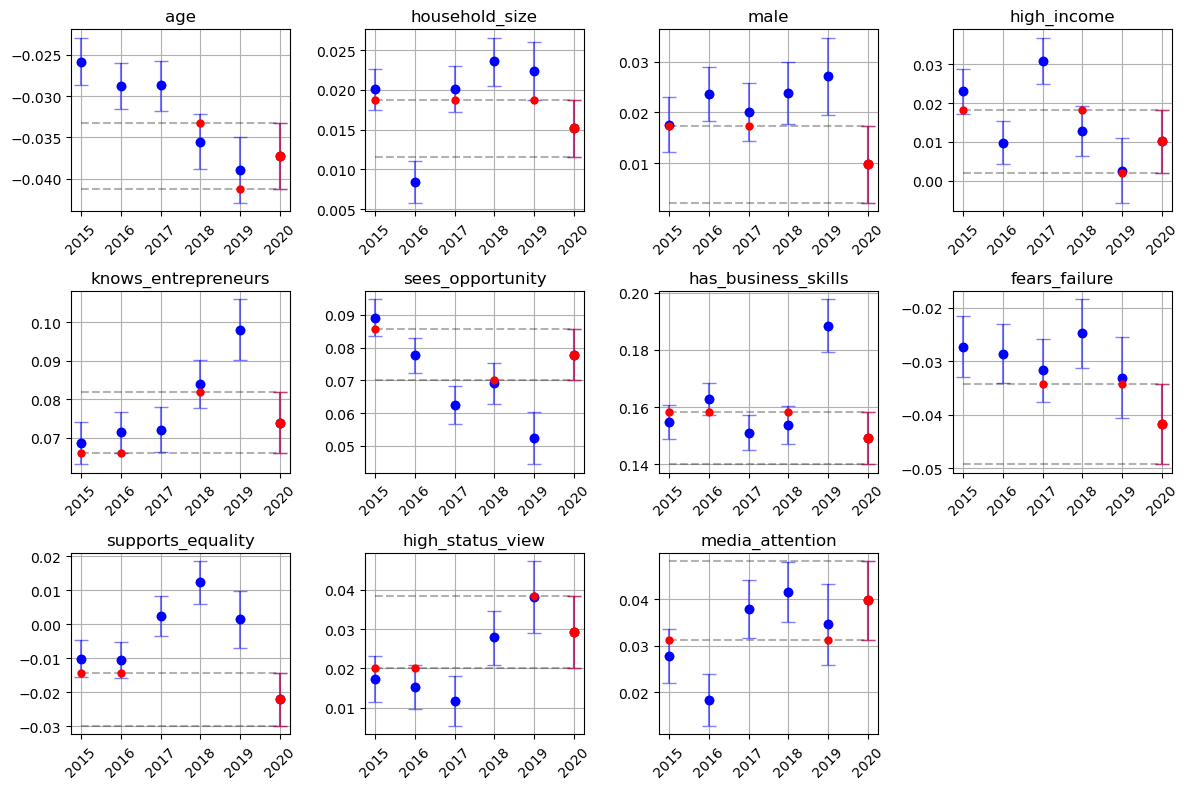

In [31]:
plot_with_CI(AME_dict, 'AME')

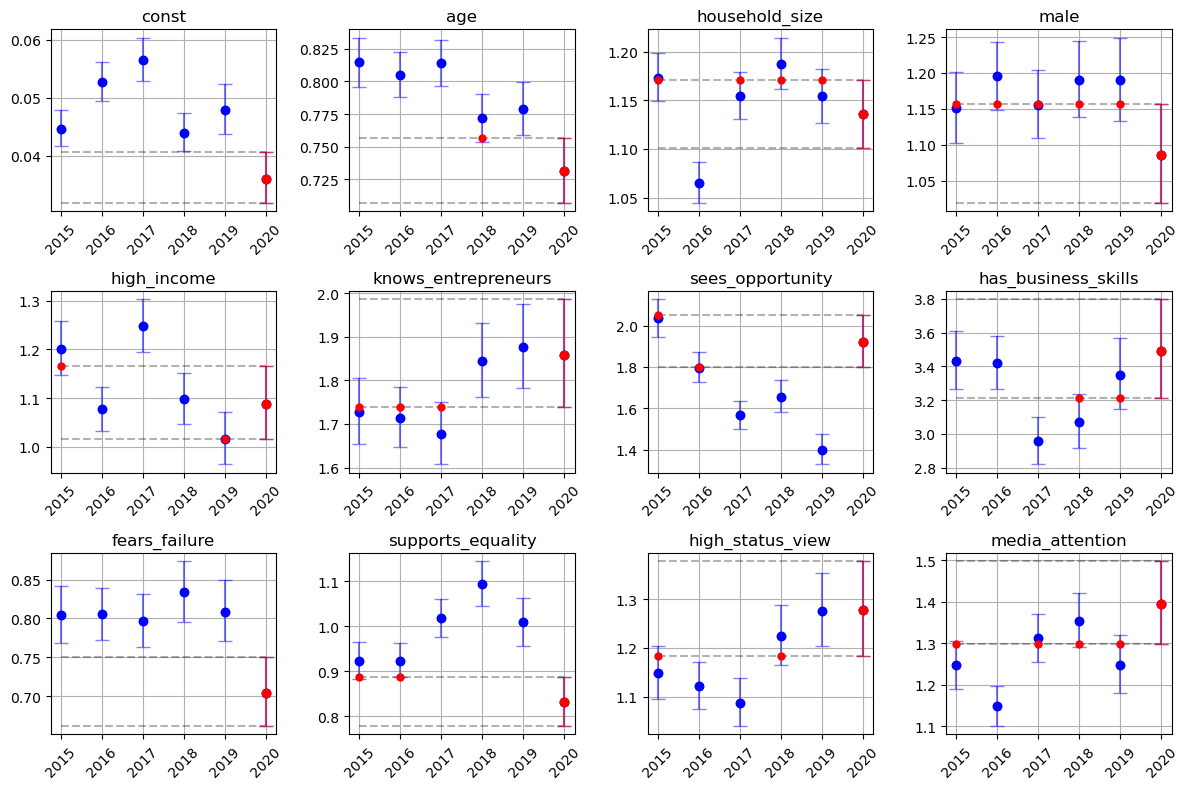

In [32]:
plot_with_CI(odds_dict, 'Odds Ratio')

# Прочие исследования

In [34]:
fear_dict = {"Предприниматели": {}, "Не предприниматели": {}}  # Создаём ключи сразу

for year, df in clean_df.items():  # Используем items() для итерации по парам "год - DataFrame"
    omit_df = df.dropna().copy()  # Убираем пропущенные значения
    
    ntrpr_df = omit_df[omit_df['enterpreneur'] == 1]  # Датафрейм предпринимателей
    no_ntrpr_df = omit_df[omit_df['enterpreneur'] == 0]  # Датафрейм не предпринимателей

    fear_dict['Предприниматели'][year] = ntrpr_df['fears_failure'].mean()
    fear_dict['Не предприниматели'][year] = no_ntrpr_df['fears_failure'].mean()

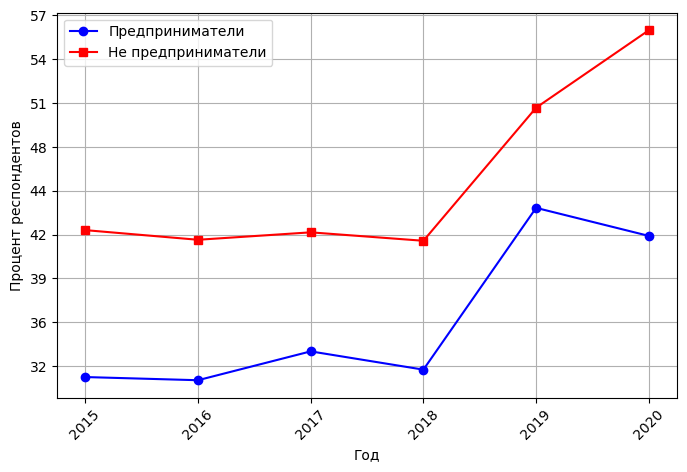

In [35]:
# Создание графика
plt.figure(figsize=(8, 5))

# Линия для предпринимателей
plt.plot(fear_dict['Предприниматели'].keys(), fear_dict['Предприниматели'].values(),
         marker='o', linestyle='-', label='Предприниматели', color='blue')

# Линия для непредпринимателей
plt.plot(fear_dict['Не предприниматели'].keys(), fear_dict['Не предприниматели'].values(),
         marker='s', linestyle='-', label='Не предприниматели', color='red')

# Разворачиваем ось X
plt.gca().invert_xaxis()

# Подписи осей и заголовок
plt.xlabel('Год')
plt.ylabel('Процент респондентов')
plt.title('')

# Форматируем Y как проценты
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# Настроим шаг по оси Y на целые числа
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Убираем десятичные знаки в числах
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x*100)}'))

# Легенда для различения линий
plt.legend()

# Поворот подписей лет для удобства чтения
plt.xticks(rotation=45)

# Сетка
plt.grid(True)

# Показываем график
plt.show()
